<a href="https://colab.research.google.com/github/anhchuc094/Forecasting-Champagne-Sales-Using-ARIMA-and-SARIMA/blob/main/Champagne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Champagne

/content/drive/MyDrive/Colab Notebooks/Champagne


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/monthly_champagne_sales.csv', parse_dates=['Month'], index_col='Month')
data = data.asfreq('MS')  # Đặt tần suất tháng đầu tháng (Month Start)
print(data.head())

            Sales
Month            
1964-01-01   2815
1964-02-01   2672
1964-03-01   2755
1964-04-01   2721
1964-05-01   2946


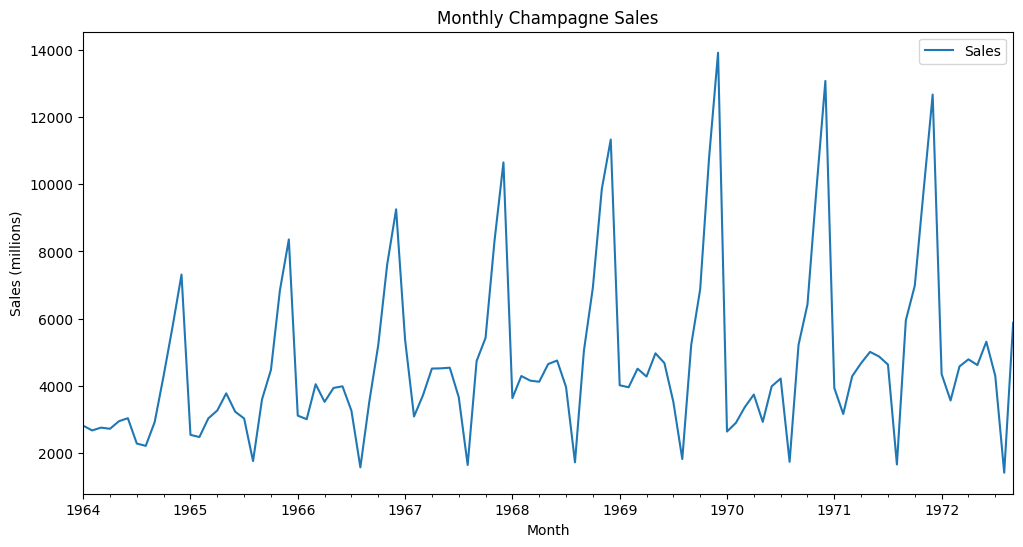

In [ ]:
# 2. Visualization ban đầu
data.plot(figsize=(12,6), title='Monthly Champagne Sales')
plt.ylabel('Sales (millions)')
plt.show()

In [ ]:
# 3. Chia dữ liệu thành tập huấn luyện và kiểm tra (80% train, 20% test)
train_size = int(len(data) * 0.8)
train, test = data['Sales'][:train_size], data['Sales'][train_size:]

In [ ]:
# 4. Biến đổi log để ổn định phương sai
train_log = np.log(train)
test_log = np.log(test)

In [ ]:
data.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [ ]:
# 5. Kiểm tra tính dừng của chuỗi log gốc
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(train_log)

Results of Dickey-Fuller Test:
Test Statistic                 -2.318639
p-value                         0.166027
#Lags Used                     11.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [ ]:
# 6. Sai phân bậc 1 để loại bỏ xu hướng
train_log_diff = train_log - train_log.shift(1)
test_log_diff = test_log - test_log.shift(1)

# 7. Loại bỏ NaN sinh ra do sai phân
train_log_diff = train_log_diff.dropna()
test_log_diff = test_log_diff.dropna()

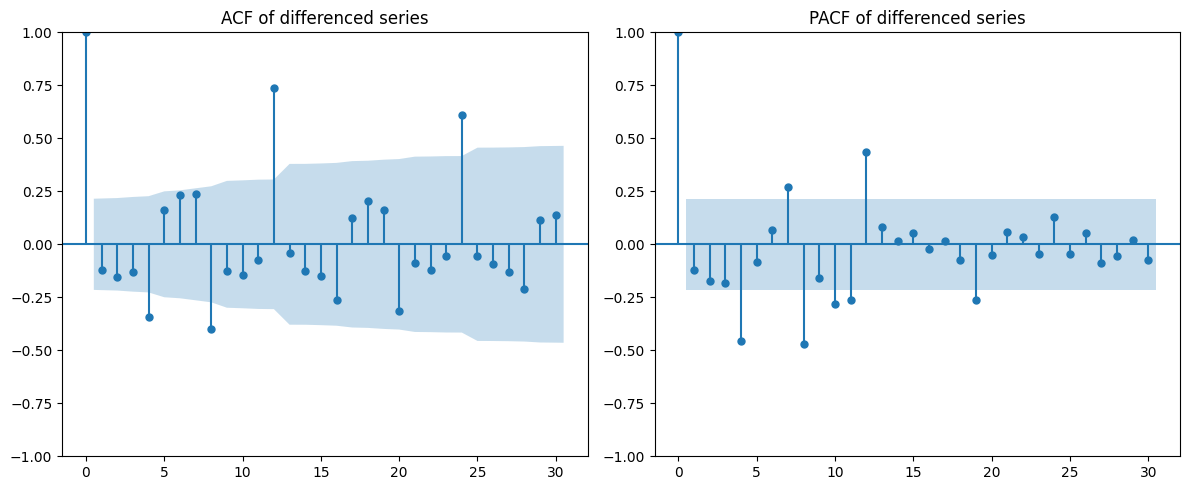

In [ ]:
# 8. Vẽ ACF và PACF để xác định tham số ARIMA
plt.figure(figsize=(12,5))
plt.subplot(121)
plot_acf(train_log_diff, lags=30, ax=plt.gca())
plt.title('ACF of differenced series')
plt.subplot(122)
plot_pacf(train_log_diff, lags=30, ax=plt.gca())
plt.title('PACF of differenced series')
plt.tight_layout()
plt.show()

In [ ]:
# 9. Xây dựng mô hình ARIMA (p=1, d=1, q=1) trên tập huấn luyện
model = ARIMA(train_log, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   84
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -48.287
Date:                Tue, 03 Jun 2025   AIC                            102.575
Time:                        10:15:32   BIC                            109.831
Sample:                    01-01-1964   HQIC                           105.490
                         - 12-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4589      0.104      4.406      0.000       0.255       0.663
ma.L1         -0.9576      0.060    -16.049      0.000      -1.075      -0.841
sigma2         0.1839      0.034      5.391      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
# 10. Dự báo trên tập kiểm tra
forecast_res = model_fit.get_forecast(steps=len(test))
forecast_series = np.exp(forecast_res.predicted_mean)  # Đảo log trở về giá trị gốc
conf_int = forecast_res.conf_int()
conf_int_exp = np.exp(conf_int)  # Đảo log khoảng tin cậy

In [ ]:
# 11. Đánh giá mô hình bằng MSE (Mean Squared Error)
mse = mean_squared_error(test, forecast_series)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 6693633.80615078


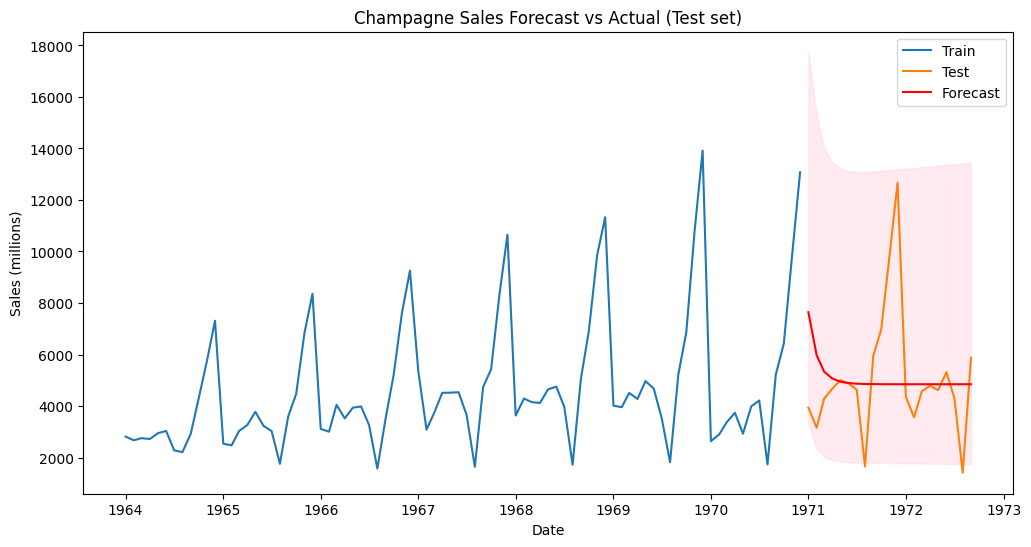

In [ ]:
# 12. Vẽ kết quả dự báo và thực tế
plt.figure(figsize=(12,6))
plt.plot(data.index[:train_size], train, label='Train')
plt.plot(data.index[train_size:], test, label='Test')
plt.plot(data.index[train_size:], forecast_series, label='Forecast', color='red')
plt.fill_between(data.index[train_size:], conf_int_exp.iloc[:, 0], conf_int_exp.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Champagne Sales Forecast vs Actual (Test set)')
plt.xlabel('Date')
plt.ylabel('Sales (millions)')
plt.legend()
plt.show()

In [ ]:
# 13. Xây dựng mô hình SARIMA (p=1, d=1, q=1, P=1, D=1, Q=1, m=12) trên tập huấn luyện
model_sarima = SARIMAX(train_log, order=(1,1,1), seasonal_order=(1,1,1,12))
model_sarima_fit = model_sarima.fit(disp=False)
print("SARIMA Model Summary:")
print(model_sarima_fit.summary())

SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  27.386
Date:                            Tue, 03 Jun 2025   AIC                            -44.772
Time:                                    10:18:55   BIC                            -33.459
Sample:                                01-01-1964   HQIC                           -40.273
                                     - 12-01-1970                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0680      0.151      0.452      0.651      -0.227       0.363
ma.L1        

In [ ]:
# 14. Dự báo trên tập kiểm tra bằng SARIMA
forecast_res_sarima = model_sarima_fit.get_forecast(steps=len(test))
forecast_series_sarima = np.exp(forecast_res_sarima.predicted_mean)  # Đảo log trở về giá trị gốc
conf_int_sarima = forecast_res_sarima.conf_int()
conf_int_exp_sarima = np.exp(conf_int_sarima)  # Đảo log khoảng tin cậy

In [ ]:
# 15. Đánh giá mô hình SARIMA bằng MSE (Mean Squared Error)
mse_sarima = mean_squared_error(test, forecast_series_sarima)
print(f'Mean Squared Error for SARIMA: {mse_sarima}')

Mean Squared Error for SARIMA: 1235170.3643481913


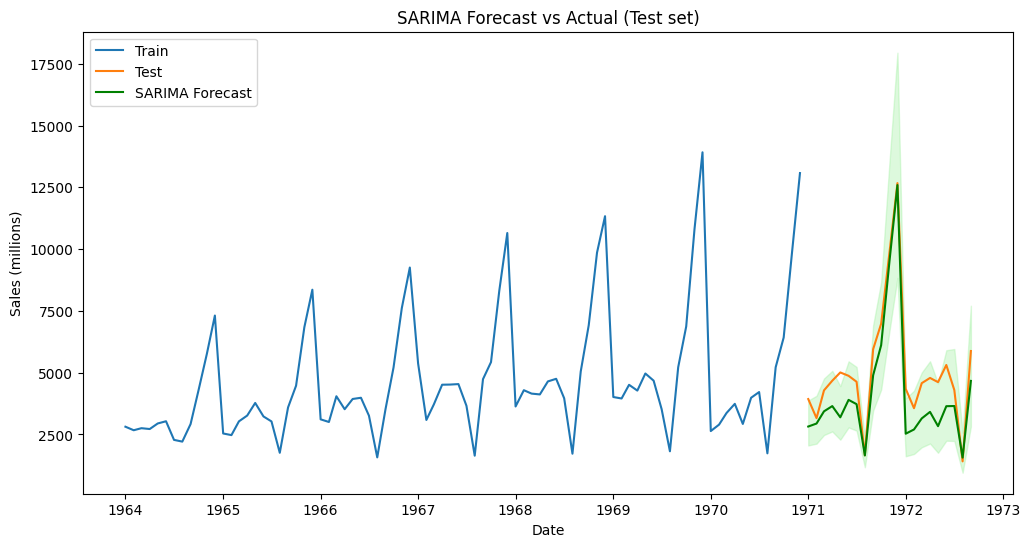

In [ ]:
# 16. Vẽ kết quả dự báo SARIMA và thực tế
plt.figure(figsize=(12,6))
plt.plot(data.index[:train_size], train, label='Train')
plt.plot(data.index[train_size:], test, label='Test')
plt.plot(data.index[train_size:], forecast_series_sarima, label='SARIMA Forecast', color='green')
plt.fill_between(data.index[train_size:], conf_int_exp_sarima.iloc[:, 0], conf_int_exp_sarima.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title('SARIMA Forecast vs Actual (Test set)')
plt.xlabel('Date')
plt.ylabel('Sales (millions)')
plt.legend()
plt.show()

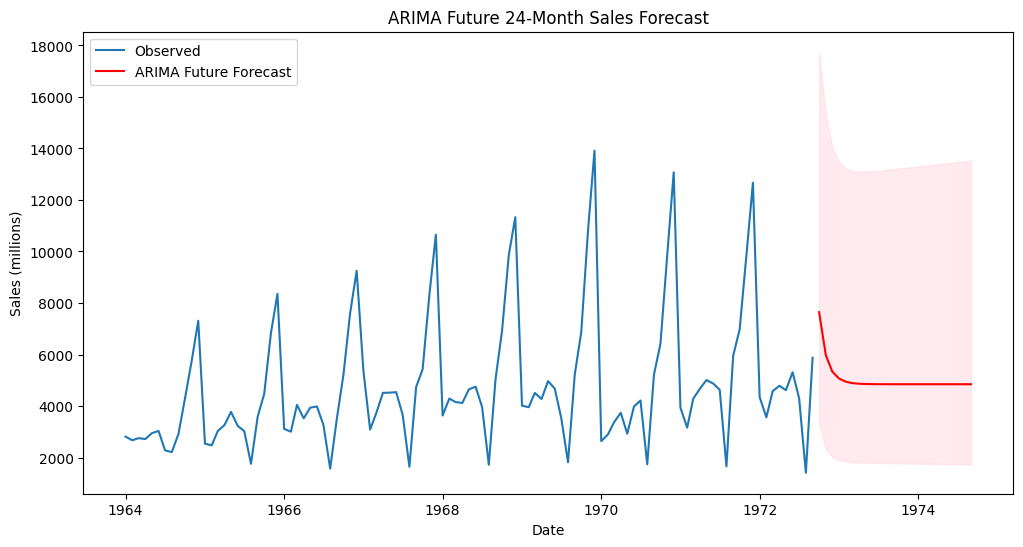

In [ ]:
future_steps = 24  # số tháng muốn dự báo tương lai
forecast_future_arima = model_fit.get_forecast(steps=future_steps)
forecast_index_future = pd.date_range(start=data.index[-1] + pd.offsets.MonthBegin(), periods=future_steps, freq='MS')
forecast_series_future_arima = np.exp(forecast_future_arima.predicted_mean)
conf_int_future_arima = forecast_future_arima.conf_int()
conf_int_exp_future_arima = np.exp(conf_int_future_arima)

plt.figure(figsize=(12,6))
plt.plot(data['Sales'], label='Observed')
plt.plot(forecast_index_future, forecast_series_future_arima, label='ARIMA Future Forecast', color='red')
plt.fill_between(forecast_index_future, conf_int_exp_future_arima.iloc[:, 0], conf_int_exp_future_arima.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Future 24-Month Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales (millions)')
plt.legend()
plt.show()

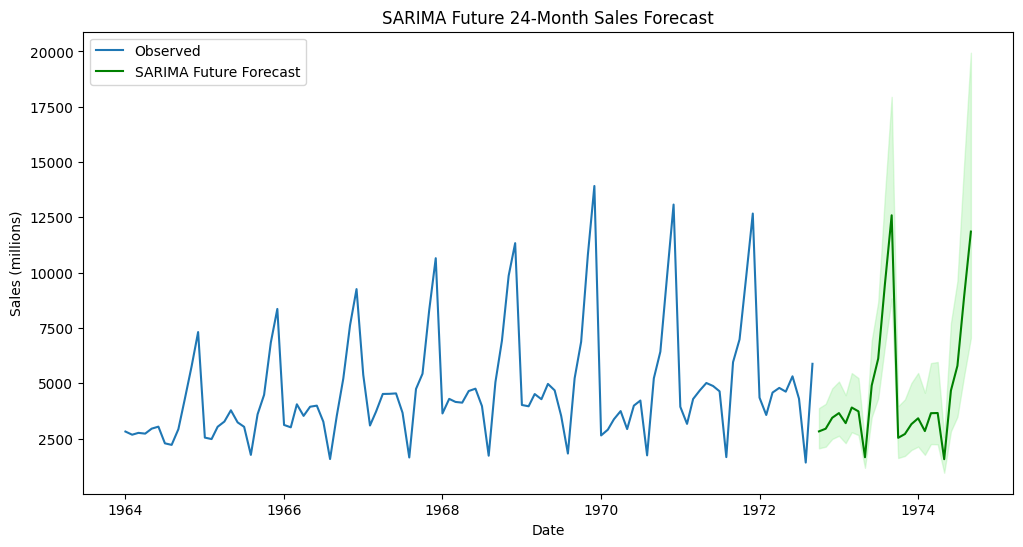

In [ ]:
# 2. Dự báo tương lai với SARIMA
forecast_future_sarima = model_sarima_fit.get_forecast(steps=future_steps)
forecast_series_future_sarima = np.exp(forecast_future_sarima.predicted_mean)
conf_int_future_sarima = forecast_future_sarima.conf_int()
conf_int_exp_future_sarima = np.exp(conf_int_future_sarima)

plt.figure(figsize=(12,6))
plt.plot(data['Sales'], label='Observed')
plt.plot(forecast_index_future, forecast_series_future_sarima, label='SARIMA Future Forecast', color='green')
plt.fill_between(forecast_index_future, conf_int_exp_future_sarima.iloc[:, 0], conf_int_exp_future_sarima.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title('SARIMA Future 24-Month Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales (millions)')
plt.legend()
plt.show()